# Trim Envelope

Calculate the set of trim points for an aircraft over a range of airspeeds
and range of flight path angles $\gamma$. The required thrust and AoA is
indicated via a colormap for each trim point.

In [ ]:
# Confirm that JSBSim is installed. If not and running on Google Colab
# then install JSBSim into the Google Colab instance.

import os

try:
  import jsbsim
  print('JSBSim is installed')
  # Relative path to the directory where the flight model is stored
  # Note - Aircraft directory needs to be writeable in order to modify the cg
  PATH_TO_JSBSIM_FILES="../.."
  print(f'Current working directory: {os.getcwd()}')
except ImportError:
  import sys
  if 'google.colab' in sys.modules:
      print('Installing JSBSim...')
      !pip install jsbsim
      # Use the standard aircraft supplied by the JSBSim Python package
      PATH_TO_JSBSIM_FILES=None

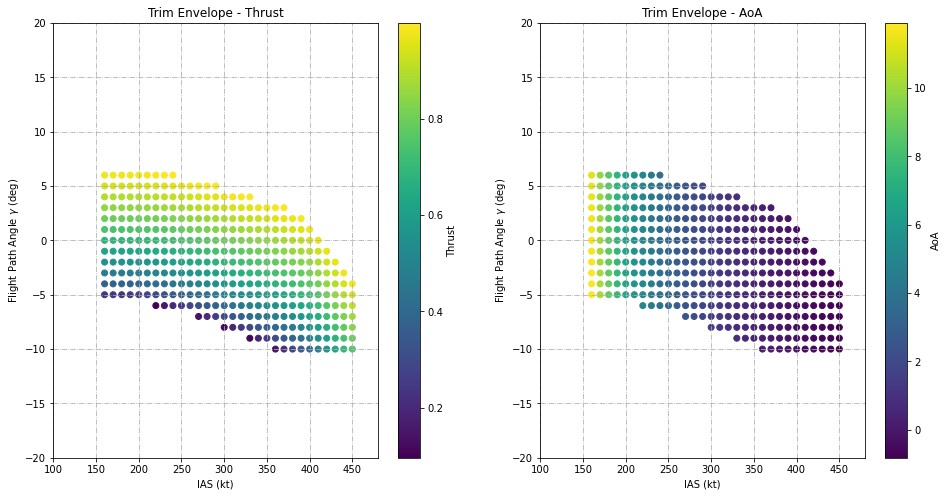

In [ ]:
import jsbsim
import matplotlib.pyplot as plt
import math

# --- Configuration Section ---
# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="737"

# --- JSBSim Initialization ---
# These lines initialize the flight dynamics model.

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

# Create a flight dynamics model (FDM) instance.
fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

# Load the aircraft model
fdm.load_model(AIRCRAFT_NAME)

# Set engines running
fdm['propulsion/set-running'] = -1


# --- Simulation Parameters ---
# These lines set the simulation parameters.

# Set alpha range for trim solutions
fdm['aero/alpha-max-rad'] = math.radians(12)   # Maximum angle of attack in radians.
fdm['aero/alpha-min-rad'] = math.radians(-4.0) # Minimum angle of attack in radians.

# Set envelope limits
min_speed = 120   # Set the minimum calibrated airspeed (kts).
max_speed = 460   # Set the maximum calibrated airspeed (kts).
altitude = 15000  # Set the altitude (ft).
min_gamma = -10   # Set the minimum flight path angle (deg).
max_gamma = 10    # Set the maximum flight path angle (deg).

# Trim results
results = []  # Initialize an empty list to store the trim results.


# --- Simulation running ---
# These lines run the simulation for each conditions.

# Iterate over a range of speeds and for each speed a range of flight path angles (gamma)
# and check whether a trim point is possible
for speed in range(min_speed, max_speed, 10):
    for gamma in range(min_gamma, max_gamma, 1):
        # set the initial conditions
        fdm['ic/h-sl-ft'] = altitude  # altitude above sea level (ft)
        fdm['ic/vc-kts'] = speed      # calibrated airspeed (kts)
        fdm['ic/gamma-deg'] = gamma   # flight path angle (deg)

        # Initialize the aircraft with initial conditions
        fdm.run_ic()

        # Trim the aircraft.
        try:
            # 1 means straight flight by using all changeable control variables.
            fdm['simulation/do_simple_trim'] = 1

            # Append the airspeed, AoA, gamma, and throttle to the results list.
            results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg'], gamma, fdm['fcs/throttle-cmd-norm[0]']))

        except jsbsim.TrimFailureError:
            pass  # Ignore trim failures


# --- Plot Results ---
# This section plots the simulation results.

# Extract the trim results
speed, alpha, gamma, throttle = zip(*results)

plt.rcParams["figure.figsize"] = (16, 8)  # Set the figure size for matplotlib plots.

# Plot the trim envelope results, with required thrust and AoA indicated via a colormap
fig, (axThrust, axAoA) = plt.subplots(1, 2)  # Create a figure with two subplots (thrust and AoA)

# Graph data for each of the sub plots (title, ax, data)
graph_data = [ ('Thrust', axThrust, throttle), ('AoA', axAoA, alpha) ]

for title, ax, data in graph_data:
    # Scatter plot with airspeed on x-axis, gamma on y-axis and either thrust setting or
    # AoA indicated via color map
    scatter = ax.scatter(speed, gamma, c=data, cmap='viridis')
    cb = fig.colorbar(scatter, ax=ax)  # Add a colorbar to the plot.
    cb.set_label(title)

    # Graph axis range for speed and gamma
    ax.set_xlim(min_speed - 20, max_speed + 20)
    ax.set_ylim(min_gamma * 2, max_gamma * 2)

    ax.grid(True, linestyle='-.')   # Add a grid to the plot.

    ax.set_xlabel('IAS (kt)')
    ax.set_ylabel('Flight Path Angle $\gamma$ (deg)')
    ax.set_title(f'Trim Envelope - {title}')

plt.show()  # Display the plot.